# Credit Fraud Detection

Credit card fraud costs about 1% of their revenue to the banks, an amount which customers
(us) eventually pay. Let's find those anomalies which might reveal a fraud. Download the
[popular credit card dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) from Kaggle.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, recall_score
from typing import Callable, List, Tuple, Any, Dict
import matplotlib.cm as cm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import random
import sys

In [2]:
# confirm if Apple GPU is available
print(f"Apple GPU available: {torch.backends.mps.is_available()}")
# confirm if cuda gpu is available
print(f"Cuda GPU available: {torch.cuda.is_available()}")

Apple GPU available: True
Cuda GPU available: False


### Helpers

<a id="evaluate"></a>
### evaluate

*The evaluate function takes the model and the data split into training and test sets. The function gets the model predictions and calculates the recall and F1 scores for the training and test sets.*

* **x_train** np.array: the training dataset 
* **y_train** np.array: the training labels
* **x_test** np.array: the testing dataset 
* **y_test** np.array: the test labels
* **model** Callable: the machine learning model

**returns** None

In [3]:
def evaluate(x_train: np.array, y_train: np.array, x_test: np.array, y_test: np.array, model: Callable) -> None:
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)

    train_rec = round(100 * recall_score(y_train, train_pred), 2)
    test_rec = round(100 * recall_score(y_test, test_pred), 2)
    train_f1 = round(100 * f1_score(y_train, train_pred), 2)
    test_f1 = round(100 * f1_score(y_test, test_pred), 2)

    print(f'Train Recall: {train_rec:.3f}, Train F1 Score: {train_f1:.3f}')
    print(f'Test Recall: {test_rec:.3f}, Test F1 Score: {test_f1:.3f}')

<a id="stratified_k_fold"></a>
### stratified_k_fold

*The stratified_k_fold function runs stratified k_fold validation using the provided model function or pipeline. Stratified k-fold validation is valuable when the dependent variable is unbalanced. The function outputs the average recall and F1 scores (with standard deviation) for the training and test sets.*

* **data** np.array: a dataset 
* **labels** List[str]: a list of feature names for the dataframe columns and rows
* **num_iter** int: number of iterations
* **n_folds** int: the number of folds
* **pipeline** Callable: a callable model or pipeline
* **with_logs** bool: print the iteration for stratified k-fold

**returns** None

In [4]:
def stratified_k_fold(data: np.array, labels: List[str], num_iter: int, n_folds: int, pipeline: Callable, with_logs:bool=False) -> None:
    train_f1s, train_recs, test_f1s, test_recs = [], [], [], []
    
    for i in range(num_iter):
        if with_logs:
            print(f"Running stratified k-fold iteration number: {i+1}")
            
        k_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=i)
        for train_idx, test_idx in k_fold.split(data, labels): 
            train_data, train_labels = data[train_idx], labels[train_idx]
            test_data, test_labels = data[test_idx], labels[test_idx]
            
            # train model
            pipeline.fit(train_data, train_labels)
            
            # make predictions
            train_predictions = pipeline.predict(train_data)
            test_predictions = pipeline.predict(test_data)
            
            # get evaluation metrics
            train_rec = round(100 * recall_score(train_labels, train_predictions), 2)
            test_rec = round(100 * recall_score(test_labels, test_predictions), 2)
            train_f1 = round(100 * f1_score(train_labels, train_predictions), 2)
            test_f1 = round(100 * f1_score(test_labels, test_predictions), 2)
            
            # append accuracies and f1 scores to results
            train_f1s.append(train_f1)
            test_f1s.append(test_f1)
            train_recs.append(train_rec)
            test_recs.append(test_rec)

    print(f'Stratified 10-fold CV Train Recall: {np.mean(train_recs):.3f} {chr(177)}{np.std(train_recs):.4f}, Train F1 Score: {np.mean(train_f1s):.3f} {chr(177)}{np.std(train_f1s):.4f} with {num_iter} iterations')
    print(f'Stratified 10-fold CV Test Recall: {np.mean(test_recs):.3f} {chr(177)}{np.std(test_recs):.4f}, Test F1 Score: {np.mean(test_f1s):.3f} {chr(177)}{np.std(test_f1s):.4f} with {num_iter} iterations')

In [5]:
# load data
credit_dataset = pd.read_csv('../EP_datasets/creditcard.csv')

## Data Exploration

In [6]:
credit_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The features V1-V28 are the result of PCA applied before downloading the dataset. The amount feature is the purchase amount, and the time is the seconds elapsed since the first transcaction in the dataset. The class variable is 1 for fraud and 0 otherwise.

In [7]:
print(f"Credit Dataset:\nrows: {credit_dataset.shape[0]} cols: {credit_dataset.shape[1]}")

Credit Dataset:
rows: 284807 cols: 31


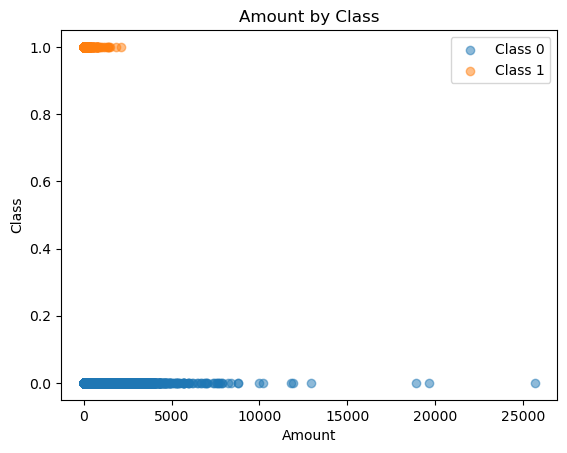

In [8]:
# scatterplot of amount
for class_value in credit_dataset['Class'].unique():
    subset = credit_dataset[credit_dataset['Class'] == class_value]
    plt.scatter(subset['Amount'], subset['Class'], label=f'Class {class_value}', alpha=0.5)
    
plt.title('Amount by Class')
plt.xlabel('Amount')
plt.ylabel('Class')
plt.legend()
plt.show()

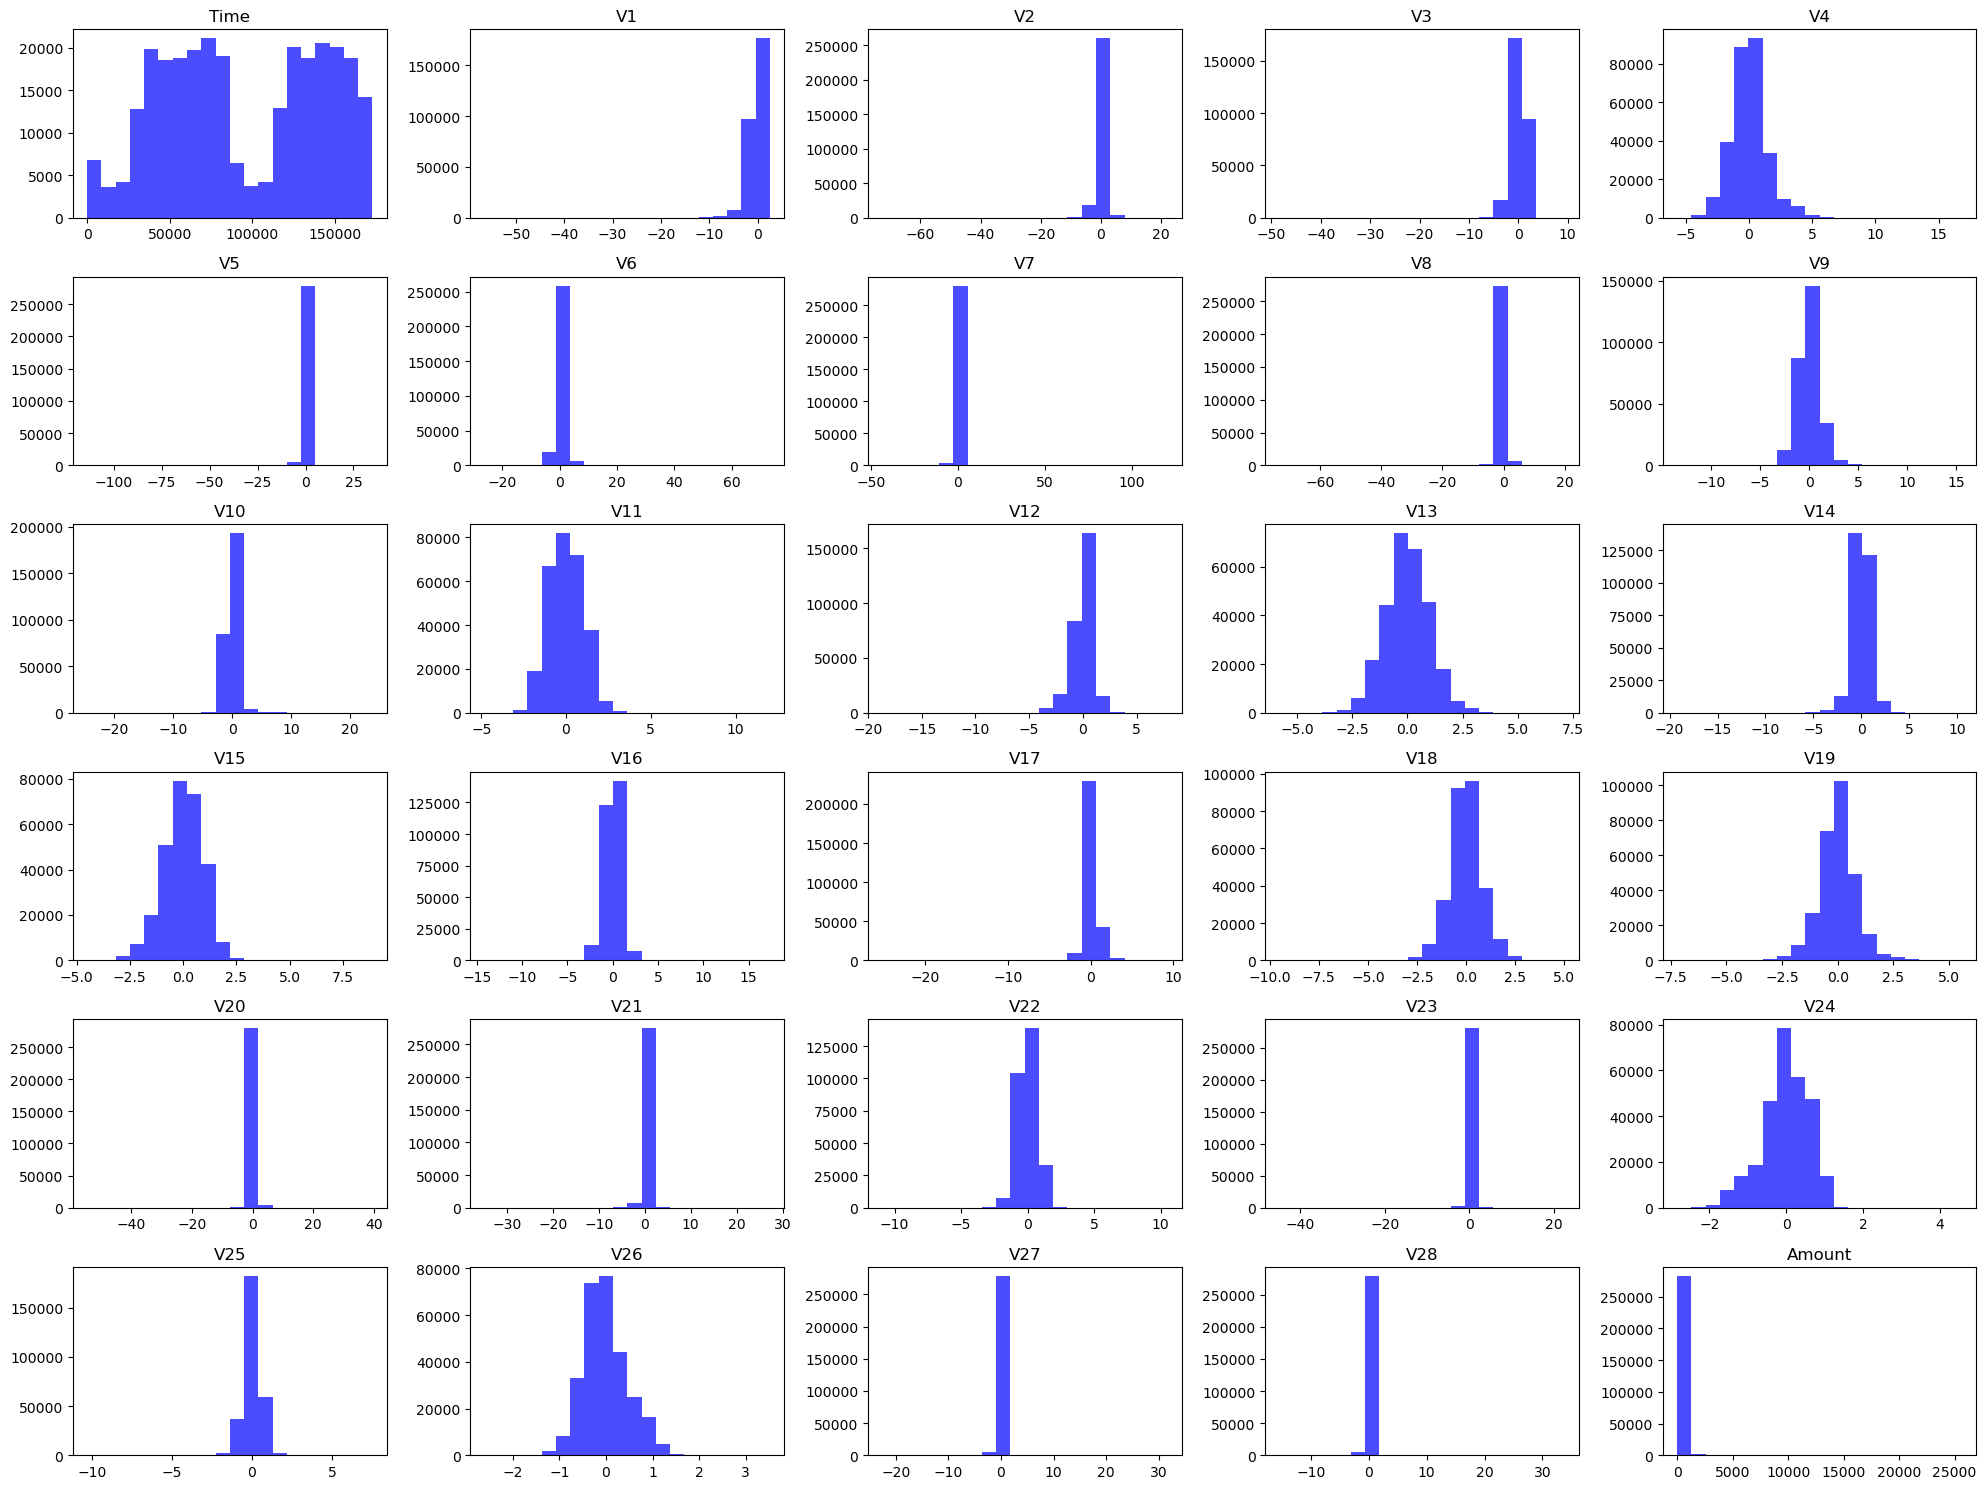

In [9]:
plot_df = credit_dataset.drop('Class', axis=1)

n_rows = 6
n_cols = 5

# create a figure object and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# flatten the array of axes for easy iteration
axes = axes.flatten()

# loop through all the features and create a histogram in each subplot
for i, col in enumerate(plot_df.columns):
    ax = axes[i]
    ax.hist(plot_df[col], bins=20, color='blue', alpha=0.7)
    ax.set_title(col)

# if there are any remaining subplots, turn them off
for i in range(len(plot_df.columns), len(axes)):
    axes[i].axis('off')


plt.tight_layout()
plt.show()

In [10]:
# check for missing values
print(f"There are {credit_dataset.isnull().sum().sum()} missing values in the credit dataset")

There are 0 missing values in the credit dataset


In [11]:
# examine feature types
types_df = pd.DataFrame(credit_dataset.dtypes, columns=['DataType'])
unique_types = list(types_df['DataType'].unique())
print(f"The dataset consists of the following feature types:\n{[dtype.name for dtype in unique_types]}")

The dataset consists of the following feature types:
['float64', 'int64']


In [12]:
# confirm that the only int value is the class label
types_df.loc[types_df['DataType'] == 'int64']

,DataType
Class,int64


The data exploration showed that the data is well-cleaned with no missing values and only a few potential outliers in the amount feature. Many of the principal component features are normally distributed and have a similar scale.

## Check the class balance and pick an evaluation metric.

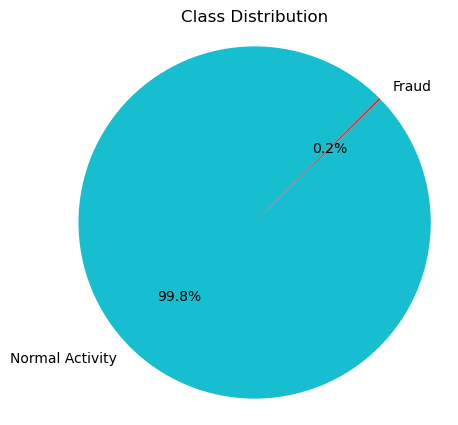

In [13]:
# plot the class distribution
fig = plt.figure(figsize=(5, 5))
labels = 'Normal Activity', 'Fraud'
hd_dist = [len(credit_dataset[credit_dataset['Class'] == 0]), len(credit_dataset[credit_dataset['Class'] == 1])] 

plt.pie(hd_dist, labels=labels, autopct='%1.1f%%', startangle=45, colors=['#17becf', '#d62728'])
plt.axis('equal')  
plt.title('Class Distribution')
plt.show()

The class distribution is heavily skued with very few positive fraud examples. The evaluation metrics will be recall because false negatives should be penalized more than false positives, and the F1 score because the classes are imbalanced. Problem 7 will use stratified k-fold validation as the evaluation technique due to the class imbalance.

The analysis in section one showed that many of the features follow a normal distribution. The dataset has already had PCA applied, and many of the features are on a similar scale. Standardization is especially effective when the underlying data approximates a Gaussian distribution. Furthermore, the higher outliers in the `amount` feature likely correspond to valid purchases, and standardization will be less sensitive to these outliers. Additionally, this analysis will apply various neural networks, and standardization is often preferred for optimization problems [1]. Therefore, standardization will provide more value to this problem.

**References**

1. S. Raschka and V. Mirjalili. *Python Machine Learning -3rd Edition*. Packt Publishing. Birmingham, UK. 

### Feature Exploration 

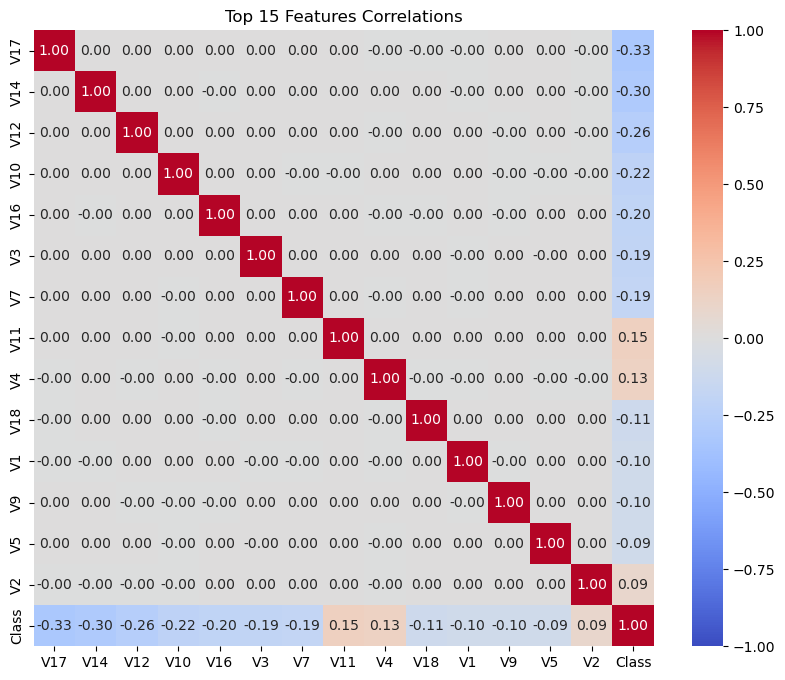

In [14]:
# get correlation matrix
correlation_matrix = credit_dataset.corr()

# get the list of features, excluding the class label
features = [col for col in credit_dataset.columns if col != 'Class']

# sort the correlations in descending order
sorted_correlations = correlation_matrix['Class'].abs().sort_values(ascending=False)

# select the top 15 most strongly correlated features
top_features = sorted_correlations[1:15].index.tolist()

# add label back to the list to include it in the heatmap
top_features.append('Class')

# display top 15 features as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top 15 Features Correlations')
plt.show()

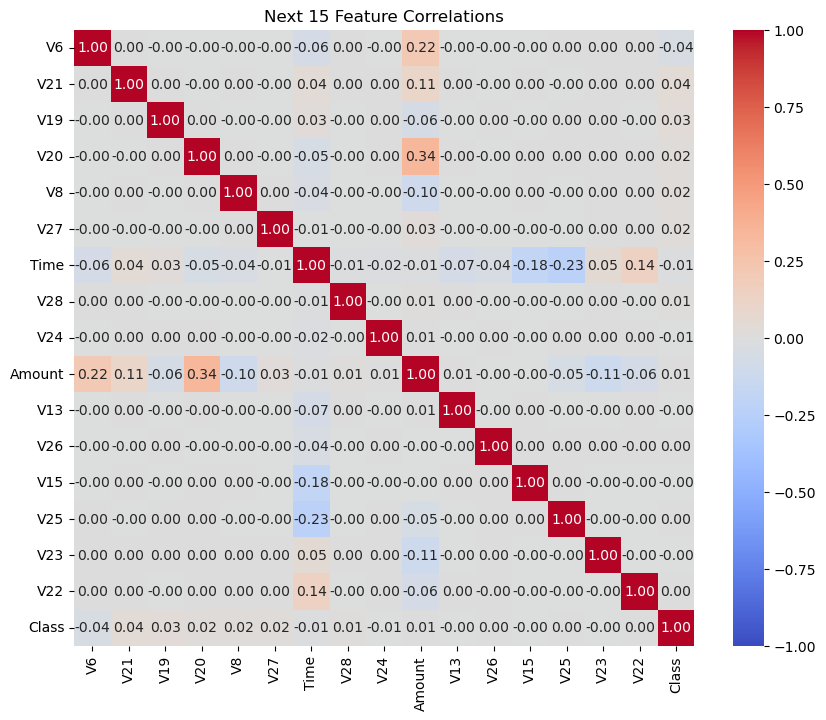

In [15]:
# select the next 15 features
top_features = sorted_correlations[15:].index.tolist()

# add label back to the list to include it in the heatmap
top_features.append('Class')

# display next 15 features as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Next 15 Feature Correlations')
plt.show()

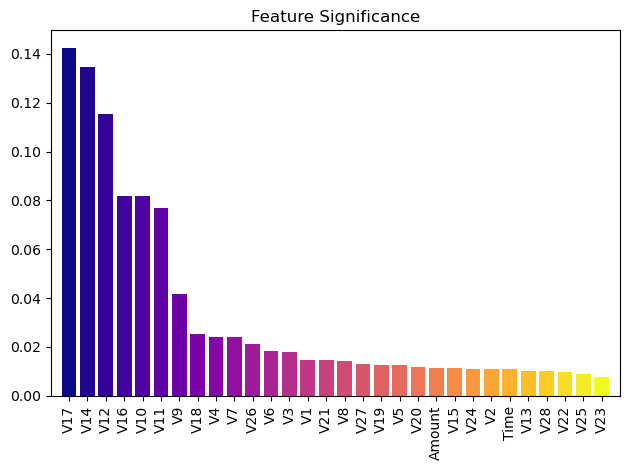

In [16]:
labels = credit_dataset['Class']
credit_data = credit_dataset.drop('Class', axis=True)

x_train, x_test, y_train, y_test = train_test_split(credit_data, labels, test_size=0.1, random_state=42)

# random forest feature significance
features = credit_data.columns

# the following code is from Python Machine Learning, 3rd Edition, pg. 141
forest = RandomForestClassifier(n_estimators=60, random_state=1)
forest.fit(x_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

colors = cm.plasma(np.linspace(0, 1, len(features)))
plt.title('Feature Significance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center', color=colors)
plt.xticks(range(x_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()

Both feature ranking methods identified features v25, v23, v22, and v13 as insignificant. Drop these features.

In [17]:
new_credit_data = credit_data.drop(['V25', 'V23', 'V22', 'V13'], axis=1)

In [18]:
# standardize the data
scaler = StandardScaler()
credit_data = scaler.fit_transform(new_credit_data)

## Run SVC, DecisionTreeClassifier, MLPClassifier, RandomForest without any tree pruning or regularization. Report the classification performance. Then run SVC, DecisionTreeClassifier, MLPClassifier with tree pruning and regularization.

In [19]:
# 50% split of training and test data
x_train, x_test, y_train, y_test = train_test_split(credit_data, labels, test_size=0.5, random_state=42)

### SVC (no regularization)

In [20]:
# set c to a very large number because the SVC class applies regularization by default with C=1.0
# increasing C decreases regularization strength
svc = SVC(C=1e05, random_state=42)
evaluate(x_train, y_train, x_test, y_test, svc)

Train Recall: 100.000, Train F1 Score: 100.000
Test Recall: 50.810, Test F1 Score: 52.970


### Decision Tree (no pruning)

In [21]:
dt = DecisionTreeClassifier(random_state=42)
evaluate(x_train, y_train, x_test, y_test, dt)

Train Recall: 100.000, Train F1 Score: 100.000
Test Recall: 76.020, Test F1 Score: 74.800


### Multilayer Perceptron (no regularization)

In [22]:
# alpha = 0 sets regularization to zero
mlp = MLPClassifier(hidden_layer_sizes = (20, 40), random_state=42, max_iter=2000, alpha=0)
evaluate(x_train, y_train, x_test, y_test, mlp)

Train Recall: 85.370, Train F1 Score: 90.320
Test Recall: 77.240, Test F1 Score: 82.790


### Random Forest

In [23]:
rf = RandomForestClassifier(n_estimators=60, max_features=5, random_state=42, n_jobs=4)
evaluate(x_train, y_train, x_test, y_test, rf)

Train Recall: 100.000, Train F1 Score: 100.000
Test Recall: 75.610, Test F1 Score: 84.350


### Results

The models above are overfitting to the training data. Applying tree pruning and regularization can help correct overfitting. The following sections find the best regularization parameters for these models using GridSearchCV. 

### SVC (regularization)

In [24]:
# define the test parameters
c_params = {
    'C': [1.0, 0.1, 0.01, 0.001]
}

# initialize the model and grid search objects
svc = SVC(random_state=42)
scorer = make_scorer(f1_score)
grid_search = GridSearchCV(svc, c_params, scoring=scorer, cv=5)

# fit the model
grid_search.fit(x_train, y_train)

# get the best parameters and the best F1 score
print("Best Parameters: ", grid_search.best_params_)
svc_c = grid_search.best_params_['C']
print(f"Best F1 Score: {round(100 * grid_search.best_score_, 3)}%")

Best Parameters:  {'C': 1.0}
Best F1 Score: 72.656%


### Decision Tree (pruning)

In [25]:
# define the test parameters
depth_params = {
    'max_depth': [2, 3, 5, 10]
}

# initialize the model and grid search objects
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, depth_params, scoring=scorer, cv=5)

# fit the model
grid_search.fit(x_train, y_train)

# get the best parameters and the best F1 score
print("Best Parameters: ", grid_search.best_params_)
dt_depth = grid_search.best_params_['max_depth']
print(f"Best F1 Score: {round(100 * grid_search.best_score_, 3)}%")

Best Parameters:  {'max_depth': 5}
Best F1 Score: 79.063%


### Multilayer Perceptron (regularization)

In [26]:
# define the test parameters (strength of the L2 term)
mlp_params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

# initialize the model and grid search object
mlp = MLPClassifier(hidden_layer_sizes = (20, 40), random_state=42, max_iter=2000)
grid_search = GridSearchCV(mlp, mlp_params, scoring=scorer, cv=5)

# fit the model
grid_search.fit(x_train, y_train)

# get the best parameters and the best F1 score
print("Best Parameters: ", grid_search.best_params_)
mlp_alpha = grid_search.best_params_['alpha']
print(f"Best F1 Score: {round(100 * grid_search.best_score_, 3)}%")

Best Parameters:  {'alpha': 0.01}
Best F1 Score: 82.603%


### Random Forest (max depth)

In [27]:
# initialize the model and grid search object
rf = RandomForestClassifier(n_estimators=60, max_features=5, random_state=42, n_jobs=4)
grid_search = GridSearchCV(rf, depth_params, scoring=scorer, cv=5)

# fit the model
grid_search.fit(x_train, y_train)

# get the best parameters and the best F1 score
print("Best Parameters: ", grid_search.best_params_)
rf_depth = grid_search.best_params_['max_depth']
print(f"Best F1 Score: {round(100 * grid_search.best_score_, 3)}%")

Best Parameters:  {'max_depth': 10}
Best F1 Score: 83.684%


In [28]:
# Report test accuracy for each model
print(f"Support Vector Machine (C={svc_c}):")
svc = SVC(C=svc_c, random_state=42)
evaluate(x_train, y_train, x_test, y_test, svc)
print(f"\nDecision Tree (Max Depth={dt_depth}):")
dt = DecisionTreeClassifier(random_state=42, max_depth=dt_depth)
evaluate(x_train, y_train, x_test, y_test, dt)
print(f"\nMultilayer Perceptron (alpha={mlp_alpha}):")
mlp = MLPClassifier(hidden_layer_sizes = (20, 40), random_state=42, max_iter=2000, alpha=mlp_alpha)
evaluate(x_train, y_train, x_test, y_test, mlp)
print(f"\nRandom Forest (max_depth={rf_depth}):")
rf = RandomForestClassifier(n_estimators=60, max_features=5, random_state=42, n_jobs=4, max_depth=rf_depth)
evaluate(x_train, y_train, x_test, y_test, rf)

Support Vector Machine (C=1.0):
Train Recall: 80.080, Train F1 Score: 88.340
Test Recall: 59.760, Test F1 Score: 73.500

Decision Tree (Max Depth=5):
Train Recall: 80.490, Train F1 Score: 86.270
Test Recall: 72.760, Test F1 Score: 79.910

Multilayer Perceptron (alpha=0.01):
Train Recall: 78.860, Train F1 Score: 85.460
Test Recall: 73.580, Test F1 Score: 82.090

Random Forest (max_depth=10):
Train Recall: 83.740, Train F1 Score: 91.150
Test Recall: 76.020, Test F1 Score: 84.420


The support vector machine had the most drastic performance increase from applying regularization. The comparison of the test performance to the training performance shows that applying regularization decreased the effect of overfitting for all models.

## Script a PyTorch neural network. Report the classification performance on the previous 50-50 dataset.

In [29]:
class PyTorchNN():
    def __init__(self, n_features, n_labels, model, epochs=500, with_logs=True, minibatch_size=100):
        self.device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
        self.model = model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.with_logs = with_logs
    
    def _reset(self):
        for m in self.model.modules():
            if isinstance(m, torch.nn.Linear):
                 m.reset_parameters()
                    
    def fit(self, x_train, y_train):
        # reset the neural network weights before training to avoid weight leakage in k fold
        self._reset()
        x_train_tensor = torch.tensor(x_train).float().to(self.device)
        y_train_tensor = torch.tensor(y_train).long().to(self.device)

        for epoch in range(self.epochs):
            total_loss = 0.0
            total_batches = 0
            indices = np.arange(x_train_tensor.shape[0])
            random.shuffle(indices)  # shuffle the data each epoch
            # pass data in batches
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                self.optimizer.zero_grad()
                
                # forward pass
                outputs = self.model(x_train_tensor[batch_idx])
                
                loss = self.loss_function(outputs, y_train_tensor[batch_idx])
    
                # backward pass
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                total_batches += 1
            # calculate avg loss for each epoch
            if self.with_logs:
                sys.stderr.write(f"\rIteration {epoch+1}/{self.epochs}  Loss: {total_loss/total_batches:6.5f}")
                sys.stderr.flush()
                
    def predict(self, x_test):
        # set model to eval mode
        self.model.eval()
        x_test_tensor = torch.tensor(x_test).float().to(self.device)
        # get predictions
        with torch.no_grad():
            outputs = self.model(x_test_tensor)
            _, predicted = torch.max(outputs.data, 1)

        return predicted.cpu().numpy()

    def evaluate(self, x_test, y_test):
        # get predictions and calculate F1 score and recall
        predicted = self.predict(x_test)
        f1 = f1_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        print(f'Recall: {recall}, F1 Score: {f1}')

In [30]:
# set features and classes
n_features = x_train.shape[1]
n_labels = 2

model = torch.nn.Sequential(
            torch.nn.Linear(n_features, 20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20, 40),
            torch.nn.Sigmoid(),
            torch.nn.Linear(40, n_labels)
        )

# initialize model and fit
model = PyTorchNN(n_features=n_features, n_labels=n_labels, model=model, epochs=50)
model.fit(x_train, np.array(y_train))

Iteration 50/50  Loss: 0.00085

In [31]:
# get reclassification metrics
print("Training Metrics:\n")
model.evaluate(x_train, np.array(y_train))
# get test accuracy
print("\nTest Metrics:\n")
model.evaluate(x_test, np.array(y_test))

Training Metrics:

Recall: 0.9552845528455285, F1 Score: 0.9418837675350701

Test Metrics:

Recall: 0.7804878048780488, F1 Score: 0.7901234567901235


The neural network above is overfitting to the trainig data and will not generalize well to new examples. 

## Add dropout to the PyTorch neural network and repeat the previous step

In [32]:
# define the model with dropout
model_2 = torch.nn.Sequential(
    # layer 1 20 hidden nodes
    torch.nn.Linear(n_features, 20),
    torch.nn.Sigmoid(),
    torch.nn.Dropout(0.2),
    # layer 2 40 hidden nodes
    torch.nn.Linear(20, 40),
    torch.nn.Sigmoid(),
    torch.nn.Dropout(0.2),
    # output layer n_classes hidden nodes
    torch.nn.Linear(40, n_labels)  
    )

# initialize model and fit
model_2 = PyTorchNN(n_features=n_features, n_labels=n_labels, model=model_2, epochs=50)
model_2.fit(x_train, np.array(y_train))

Iteration 50/50  Loss: 0.00218

In [33]:
# get reclassification metrics
print("\nTraining Metrics:\n")
model_2.evaluate(x_train, np.array(y_train))
# get test accuracy
print("\nTest Metrics:\n")
model_2.evaluate(x_test, np.array(y_test))


Training Metrics:

Recall: 0.8536585365853658, F1 Score: 0.8768267223382047

Test Metrics:

Recall: 0.7723577235772358, F1 Score: 0.8102345415778253


Applying regularization using dropout layers to the neural network above achieved a slightly higher F1 score than the neural network in the previous cell. However, comparing the training F1 score to the test F1 score showed that the dropout layers made the model more generalizable and reduced overfitting. A robust model that generalizes well to new examples is always preferred over a model that is overfitting to the training data. 

## Evaluate the 10-fold cross validation of Random Forest and the PyTorch Neural Networks

Note: the code below runs stratified 10-fold validation on only 50% of the data due to time constraints with running the code. The plot below ensures that the class distribution for the data sample is the same as the class distribution for the entire dataset. Even with the reduced dataset, the code below takes several hours to run on an Apple GPU.

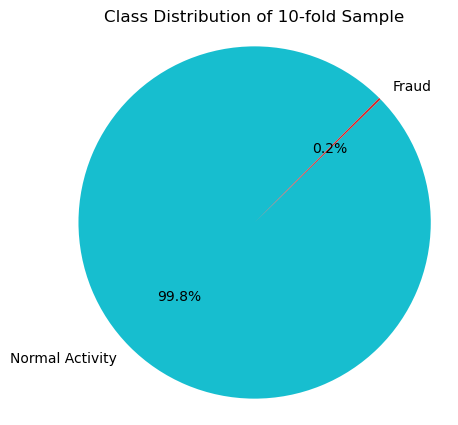

In [34]:
# plot the class distribution of the training data
fig = plt.figure(figsize=(5, 5))
labels = 'Normal Activity', 'Fraud'
hd_dist = [len(y_test)-sum(y_test), sum(y_test), ] 

plt.pie(hd_dist, labels=labels, autopct='%1.1f%%', startangle=45, colors=['#17becf', '#d62728'])
plt.axis('equal')  
plt.title('Class Distribution of 10-fold Sample')
plt.show()

In [35]:
# use the best depth identified above
rf = RandomForestClassifier(n_estimators=60, 
                                  max_features=5, 
                                  random_state=42, 
                                  n_jobs=4, 
                                  max_depth=rf_depth)
# run stratified k-fold
stratified_k_fold(x_test, np.array(y_test), 5, 10, rf)

Stratified 10-fold CV Train Recall: 84.996 ±0.8950, Train F1 Score: 91.883 ±0.5305 with 5 iterations
Stratified 10-fold CV Test Recall: 77.146 ±7.6365, Test F1 Score: 84.933 ±4.9739 with 5 iterations


In [36]:
# define the first model
model = torch.nn.Sequential(
        torch.nn.Linear(n_features, 20),
        torch.nn.Sigmoid(),
        torch.nn.Linear(20, 40),
        torch.nn.Sigmoid(),
        torch.nn.Linear(40, n_labels)
    )
model_1 = PyTorchNN(n_features=n_features, n_labels=n_labels, model=model, epochs=50, with_logs=False)

# run stratified k-fold
stratified_k_fold(x_test, np.array(y_test), 5, 10, model_1, True)

Running stratified k-fold iteration number: 1
Running stratified k-fold iteration number: 2
Running stratified k-fold iteration number: 3
Running stratified k-fold iteration number: 4
Running stratified k-fold iteration number: 5
Stratified 10-fold CV Train Recall: 91.821 ±5.7442, Train F1 Score: 91.807 ±2.2297 with 5 iterations
Stratified 10-fold CV Test Recall: 75.150 ±10.2763, Test F1 Score: 77.983 ±6.6216 with 5 iterations


In [37]:
# define the second model
model_2 = torch.nn.Sequential(
        # layer 1 20 hidden nodes
        torch.nn.Linear(n_features, 20),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(0.2),
        # layer 2 40 hidden nodes
        torch.nn.Linear(20, 40),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(0.2),
        # output layer n_classes hidden nodes
        torch.nn.Linear(40, n_labels)  
        )
model_2 = PyTorchNN(n_features=n_features, n_labels=n_labels, model=model_2, epochs=50, with_logs=False)

# run stratified k-fold
stratified_k_fold(x_test, np.array(y_test), 5, 10, model_2, True)

Running stratified k-fold iteration number: 1
Running stratified k-fold iteration number: 2
Running stratified k-fold iteration number: 3
Running stratified k-fold iteration number: 4
Running stratified k-fold iteration number: 5
Stratified 10-fold CV Train Recall: 93.454 ±4.6141, Train F1 Score: 91.884 ±2.2124 with 5 iterations
Stratified 10-fold CV Test Recall: 78.113 ±9.0060, Test F1 Score: 79.148 ±5.9266 with 5 iterations


### Conclusions
- The random forest model achieved the best performance for the problem of credit fraud detection.
- The PyTorch model with dropout layers achieved better performance than the neural network without dropout.
- The dropout layers slightly reduced the effect of overfitting. Increasing the dropout threshold could help the model generalize better to unseen data. 